In [1]:
import keras
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import (
    Dense, Embedding, LSTM, GRU, Conv2D,
    Input, Flatten, Dropout, Activation, BatchNormalization,
    Convolution2D, MaxPooling2D, Dropout, MaxPool2D)
from keras.utils import np_utils, to_categorical

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.losses import CategoricalCrossentropy
from keras import backend as K

import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import pickle
from tensorflow.python.ops import gen_audio_ops as audio_ops
from matplotlib.pyplot import specgram
from tensorflow.python.ops import io_ops
import tensorflow as tf
import soundfile as sf
import os

In [2]:
df = pd.read_csv('../data/data.csv')
df = df.drop(columns=['Unnamed: 0'], axis=1)

In [3]:
def cut_data(data, length):
    if data.shape[0] > length:
        data = data[:length]
    elif data.shape[0] < length:
        need_len = length - data.shape[0]
        add_len = need_len // 2
        data = np.concatenate([add_len * [0], data, (need_len - add_len) * [0]])
    return data 

In [4]:
temp = []

counter=0
max_len = 0
for index,path in enumerate(df.path):
    X, sr = librosa.load(path, sr=44100)
    X = cut_data(X, 314818)
    wav_path_for_convert = 'temp_for_convert.wav'
    sf.write(wav_path_for_convert, X, sr)
    wav_loader = io_ops.read_file(wav_path_for_convert)
    waveform = audio_ops.decode_wav(wav_loader, desired_channels=1)    
    spectrogram = audio_ops.audio_spectrogram(
        waveform.audio, 
        window_size=int((44100 * 40) / 1000), 
        stride=int(44100 * 20 / 1000)
    )
    spectrogram = tf.cast(spectrogram, float)
    mfcc = audio_ops.mfcc(
        spectrogram=spectrogram,
        sample_rate=44100,
        upper_frequency_limit=7600,
        lower_frequency_limit=20,
        filterbank_channel_count=40,
        dct_coefficient_count=20
    )
    mfcc = tf.squeeze(mfcc, axis=0)
    mfcc = mfcc.numpy()
    mfcc = np.expand_dims(mfcc, axis=0)
    temp.append(mfcc)   
    if counter > 0 and counter % 250 == 0:
        print(counter, mfcc.shape)
    counter += 1

250 (1, 355, 20)
500 (1, 355, 20)
750 (1, 355, 20)
1000 (1, 355, 20)
1250 (1, 355, 20)
1500 (1, 355, 20)
1750 (1, 355, 20)
2000 (1, 355, 20)
2250 (1, 355, 20)
2500 (1, 355, 20)
2750 (1, 355, 20)
3000 (1, 355, 20)
3250 (1, 355, 20)
3500 (1, 355, 20)
3750 (1, 355, 20)
4000 (1, 355, 20)
4250 (1, 355, 20)
4500 (1, 355, 20)
4750 (1, 355, 20)
5000 (1, 355, 20)
5250 (1, 355, 20)
5500 (1, 355, 20)
5750 (1, 355, 20)
6000 (1, 355, 20)
6250 (1, 355, 20)
6500 (1, 355, 20)
6750 (1, 355, 20)
7000 (1, 355, 20)
7250 (1, 355, 20)
7500 (1, 355, 20)
7750 (1, 355, 20)
8000 (1, 355, 20)
8250 (1, 355, 20)
8500 (1, 355, 20)
8750 (1, 355, 20)
9000 (1, 355, 20)
9250 (1, 355, 20)
9500 (1, 355, 20)
9750 (1, 355, 20)
10000 (1, 355, 20)
10250 (1, 355, 20)
10500 (1, 355, 20)
10750 (1, 355, 20)
11000 (1, 355, 20)
11250 (1, 355, 20)
11500 (1, 355, 20)
11750 (1, 355, 20)
12000 (1, 355, 20)


In [18]:
path = df.path[1001]
wav_loader = io_ops.read_file(path)
waveform = audio_ops.decode_wav(wav_loader, desired_channels=1)    
spectrogram = audio_ops.audio_spectrogram(
    waveform.audio, 
    window_size=int((44100 * 40) / 1000), 
    stride=int(44100 * 20 / 1000)
)
spectrogram = tf.cast(spectrogram, float)
mfcc = audio_ops.mfcc(
    spectrogram=spectrogram,
    sample_rate=44100,
    upper_frequency_limit=7600,
    lower_frequency_limit=20,
    filterbank_channel_count=40,
    dct_coefficient_count=20
)
mfcc = tf.squeeze(mfcc, axis=0)
mfcc = mfcc.numpy()
mfcc = np.expand_dims(mfcc, axis=0)

In [19]:
mfcc.shape

(1, 215, 20)

In [5]:
X = np.concatenate(temp, axis=0)

In [6]:
X.shape

(12162, 355, 20)

In [7]:
filename = 'MfccData30'
outfile = open(filename,'wb')
pickle.dump(X,outfile)
outfile.close()

In [3]:
filename = '../../../MfccData30'
outfile = open(filename,'rb')
X = pickle.load(outfile)
outfile.close()

In [4]:
X.shape

(12162, 355, 20)

In [36]:
def CNN_model(input_shape, nclass):
    
    inp = Input(input_shape)
    
    x = Convolution2D(32, (3, 5), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(64, (3, 5), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(128, (3, 5), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(256, (3, 5), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Dense(256)(x)
    x = Dropout(rate=0.2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.2)(x)
    
    out = Dense(nclass, activation='softmax')(x)
    
    ret_model = Model(inputs = inp, outputs=out)
    
    return ret_model

In [18]:
def save_model(Model, model_name):
    save_dir = os.path.join(os.getcwd(), 'saved_models')

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    Model.save(model_path)
    print('Save model and weights at %s ' % model_path)

    model_json = Model.to_json()
    with open("model_json.json", "w") as json_file:
        json_file.write(model_json)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X
                                                    , df.labels
                                                    , test_size=0.08
                                                    , shuffle=True
                                                    , random_state=42)

In [7]:
print(f'X_train size = {X_train.shape}')
print(f'Y_train size = {Y_train.shape}')
print(f'X_test size = {X_test.shape}')
print(f'Y_test size = {Y_test.shape}')

X_train size = (11189, 355, 20)
Y_train size = (11189,)
X_test size = (973, 355, 20)
Y_test size = (973,)


In [8]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [9]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [10]:
lb = LabelEncoder()
Y_train = np_utils.to_categorical(lb.fit_transform(Y_train))
Y_test = np_utils.to_categorical(lb.fit_transform(Y_test))
print(lb.classes_)

['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [11]:
print(f'Y_train size = {Y_train.shape}')
print(f'Y_test size = {Y_test.shape}')

Y_train size = (11189, 14)
Y_test size = (973, 14)


In [12]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
print(f'X_train size = {X_train.shape}')
print(f'X_test size = {X_test.shape}')

X_train size = (11189, 355, 20, 1)
X_test size = (973, 355, 20, 1)


In [37]:
cnn_model = CNN_model((355, 20, 1), 14)
opt = Adam(0.001)
cnn_model.compile(optimizer = opt, loss=CategoricalCrossentropy(from_logits=True), metrics = ["accuracy"])

In [38]:
cnn_model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 355, 20, 1)]      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 355, 20, 32)       512       
_________________________________________________________________
batch_normalization_39 (Batc (None, 355, 20, 32)       128       
_________________________________________________________________
activation_39 (Activation)   (None, 355, 20, 32)       0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 177, 10, 32)       0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 177, 10, 32)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 177, 10, 64)       3078

In [39]:
model_history_1 = cnn_model.fit(x = X_train, y = Y_train, epochs = 10, batch_size = 64, validation_data=(X_test, Y_test))

Epoch 1/10
175/175 [==============================] - 97s 547ms/step - loss: 2.3790 - accuracy: 0.2241 - val_loss: 2.8898 - val_accuracy: 0.1336
Epoch 2/10
175/175 [==============================] - 96s 548ms/step - loss: 1.4419 - accuracy: 0.4905 - val_loss: 1.5546 - val_accuracy: 0.4553
Epoch 3/10
175/175 [==============================] - 90s 514ms/step - loss: 1.2181 - accuracy: 0.5591 - val_loss: 1.3589 - val_accuracy: 0.5498
Epoch 4/10
175/175 [==============================] - 90s 512ms/step - loss: 1.1276 - accuracy: 0.5881 - val_loss: 1.2857 - val_accuracy: 0.5519
Epoch 5/10
175/175 [==============================] - 90s 513ms/step - loss: 1.0108 - accuracy: 0.6206 - val_loss: 1.5812 - val_accuracy: 0.4923
Epoch 6/10
175/175 [==============================] - 89s 510ms/step - loss: 0.9869 - accuracy: 0.6364 - val_loss: 1.1601 - val_accuracy: 0.5766
Epoch 7/10
175/175 [==============================] - 90s 512ms/step - loss: 0.9160 - accuracy: 0.6608 - val_loss: 1.0828 - val_ac

In [41]:
K.set_value(cnn_model.optimizer.learning_rate, 0.0001)

In [42]:
model_history_2 = cnn_model.fit(x = X_train, y = Y_train, epochs = 20, batch_size = 64, validation_data=(X_test, Y_test))

Epoch 1/20
175/175 [==============================] - 93s 533ms/step - loss: 0.6521 - accuracy: 0.7599 - val_loss: 0.9483 - val_accuracy: 0.6732
Epoch 2/20
175/175 [==============================] - 90s 514ms/step - loss: 0.6164 - accuracy: 0.7739 - val_loss: 1.0394 - val_accuracy: 0.6423
Epoch 3/20
175/175 [==============================] - 91s 521ms/step - loss: 0.5940 - accuracy: 0.7893 - val_loss: 0.9877 - val_accuracy: 0.6629
Epoch 4/20
175/175 [==============================] - 88s 502ms/step - loss: 0.5814 - accuracy: 0.7822 - val_loss: 1.0369 - val_accuracy: 0.6506
Epoch 5/20
175/175 [==============================] - 88s 505ms/step - loss: 0.5562 - accuracy: 0.8007 - val_loss: 0.9697 - val_accuracy: 0.6701
Epoch 6/20
175/175 [==============================] - 88s 504ms/step - loss: 0.5388 - accuracy: 0.8025 - val_loss: 0.9443 - val_accuracy: 0.6691
Epoch 7/20
175/175 [==============================] - 88s 504ms/step - loss: 0.5385 - accuracy: 0.8045 - val_loss: 0.9787 - val_ac

In [43]:
K.set_value(cnn_model.optimizer.learning_rate, 0.00001)

In [44]:
model_history_3 = cnn_model.fit(x = X_train, y = Y_train, epochs = 10, batch_size = 64, validation_data=(X_test, Y_test))

Epoch 1/10
175/175 [==============================] - 88s 503ms/step - loss: 0.3925 - accuracy: 0.8623 - val_loss: 1.0465 - val_accuracy: 0.6629
Epoch 2/10
175/175 [==============================] - 88s 501ms/step - loss: 0.3872 - accuracy: 0.8599 - val_loss: 1.0390 - val_accuracy: 0.6701
Epoch 3/10
175/175 [==============================] - 88s 501ms/step - loss: 0.3903 - accuracy: 0.8589 - val_loss: 1.0185 - val_accuracy: 0.6773
Epoch 4/10
175/175 [==============================] - 88s 500ms/step - loss: 0.3826 - accuracy: 0.8626 - val_loss: 1.0181 - val_accuracy: 0.6783
Epoch 5/10
175/175 [==============================] - 88s 500ms/step - loss: 0.3771 - accuracy: 0.8682 - val_loss: 1.0476 - val_accuracy: 0.6670
Epoch 6/10
175/175 [==============================] - 88s 501ms/step - loss: 0.3742 - accuracy: 0.8654 - val_loss: 1.0342 - val_accuracy: 0.6732
Epoch 7/10
175/175 [==============================] - 87s 497ms/step - loss: 0.3786 - accuracy: 0.8642 - val_loss: 1.0521 - val_ac

In [45]:
K.set_value(cnn_model.optimizer.learning_rate, 0.000001)
model_history_4 = cnn_model.fit(x = X_train, y = Y_train, epochs = 10, batch_size = 64, validation_data=(X_test, Y_test))

Epoch 1/10
175/175 [==============================] - 87s 496ms/step - loss: 0.3737 - accuracy: 0.8687 - val_loss: 1.0668 - val_accuracy: 0.6608
Epoch 2/10
175/175 [==============================] - 87s 494ms/step - loss: 0.3781 - accuracy: 0.8647 - val_loss: 1.0453 - val_accuracy: 0.6711
Epoch 3/10
175/175 [==============================] - 87s 495ms/step - loss: 0.3833 - accuracy: 0.8676 - val_loss: 1.0522 - val_accuracy: 0.6660
Epoch 4/10
175/175 [==============================] - 87s 496ms/step - loss: 0.3881 - accuracy: 0.8616 - val_loss: 1.0529 - val_accuracy: 0.6670
Epoch 5/10
175/175 [==============================] - 87s 494ms/step - loss: 0.3794 - accuracy: 0.8663 - val_loss: 1.0491 - val_accuracy: 0.6701
Epoch 6/10
175/175 [==============================] - 87s 495ms/step - loss: 0.3780 - accuracy: 0.8642 - val_loss: 1.0308 - val_accuracy: 0.6742
Epoch 7/10
175/175 [==============================] - 87s 495ms/step - loss: 0.3753 - accuracy: 0.8653 - val_loss: 1.0597 - val_ac

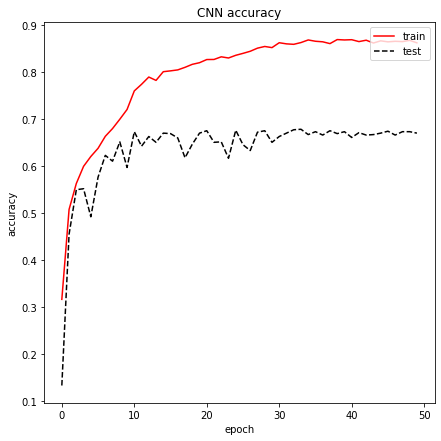

In [50]:
model_history_acc = []
model_history_val_acc = []

model_history_acc += model_history_1.history['accuracy']
model_history_acc += model_history_2.history['accuracy']
model_history_acc += model_history_3.history['accuracy']
model_history_acc += model_history_4.history['accuracy']

model_history_val_acc += model_history_1.history['val_accuracy']
model_history_val_acc += model_history_2.history['val_accuracy']
model_history_val_acc += model_history_3.history['val_accuracy']
model_history_val_acc += model_history_4.history['val_accuracy']

fig = plt.figure(figsize=(7,7))
plt.plot(model_history_acc, color="red", label='train')
plt.plot(model_history_val_acc, color="black", label='test', linestyle="dashed")
plt.title('CNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.savefig("CNN2_emotion_accuracy.jpg", facecolor=fig.get_facecolor(), transparent=True)
plt.show()

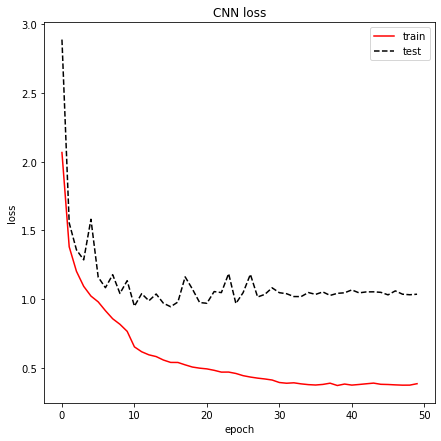

In [54]:
model_history_acc = []
model_history_val_acc = []

model_history_acc += model_history_1.history['loss']
model_history_acc += model_history_2.history['loss']
model_history_acc += model_history_3.history['loss']
model_history_acc += model_history_4.history['loss']

model_history_val_acc += model_history_1.history['val_loss']
model_history_val_acc += model_history_2.history['val_loss']
model_history_val_acc += model_history_3.history['val_loss']
model_history_val_acc += model_history_4.history['val_loss']

fig = plt.figure(figsize=(7,7))
plt.plot(model_history_acc, color="red", label='train')
plt.plot(model_history_val_acc, color="black", label='test', linestyle="dashed")
plt.title('CNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.savefig("CNN2_emotion_loss.jpg", facecolor=fig.get_facecolor(), transparent=True)
plt.show()

In [48]:
def report(model, X, y, classes):
    model_predictions = model.predict(X, batch_size=64).argmax(axis=1)
    true_predictions = y.argmax(axis=1)
    return classification_report(true_predictions, model_predictions, target_names=classes)

In [49]:
print(report(cnn_model, X_test, Y_test, lb.classes_))

                 precision    recall  f1-score   support

   female_angry       0.86      0.72      0.79        87
 female_disgust       0.87      0.65      0.75       104
    female_fear       0.66      0.79      0.72        85
   female_happy       0.78      0.72      0.75        92
 female_neutral       0.71      0.82      0.76        66
     female_sad       0.68      0.87      0.76        77
female_surprise       1.00      1.00      1.00        41
     male_angry       0.89      0.44      0.59        78
   male_disgust       0.56      0.56      0.56        61
      male_fear       0.43      0.57      0.49        67
     male_happy       0.57      0.33      0.42        69
   male_neutral       0.61      0.61      0.61        64
       male_sad       0.45      0.74      0.56        72
  male_surprise       0.45      0.50      0.48        10

       accuracy                           0.67       973
      macro avg       0.68      0.67      0.66       973
   weighted avg       0.70   

In [53]:
cnn_model.save(os.path.join(os.getcwd(), 'CNN2_emotion.h5'), save_format="h5")

In [86]:
len(model_history_1.history['val_loss'])

8

In [55]:
val_1 = ['a', 'b', 'c']
val_2 = ['kk', 'gg', 'hh']

for in1, in2 in zip(val_1, val_2):
    print(in1, in2)

a kk
b gg
c hh
